<a href="https://colab.research.google.com/github/esterjara/CloserLookFewShotDataAugmentation/blob/master/colab/DALLE_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL-E Mini
________________________________________________

Generate images from a text prompt. 

This notebook illustrates DALL·E mini inference pipeline. This neural network generates images used to perform a data augmentation on the novel class of the CIFAR-100 dataset. This generated set concatenated to the original is used as a support set for the few-shot classification process.

https://github.com/wyharveychen/CloserLookFewShot, Copyright (c) 2019 Wei-Yu Chen

https://github.com/borisdayma/dalle-mini, Copyright (c) 2021 Boris Dayma

https://openai.com/blog/dall-e/, Copyright (c) 2021 OpenAI

https://github.com/openai/CLIP, Copyright (c) 2021 OpenAI


#### Download

In [ ]:
# Install required libraries
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git
!pip install -q git+https://github.com/borisdayma/dalle-mini.git

We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

##### Image generation from notebook

In [ ]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [ ]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

In [ ]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model_dalle, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

Model parameters are replicated on each device for faster inference.

In [ ]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [ ]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model_dalle.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

We can rank images according to CLIP.

In [ ]:
# OPTIONAL
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
import random
from flax.training.common_utils import shard

from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

In [ ]:
# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

In [ ]:
test_labels = ['baby', 'bed', 'bicycle', 'chimpanzee', 'fox', 'leopard', 'man', 'pickup_truck', 'plain', 'poppy', 'rocket', 'rose', 'snail', 'sweet_pepper', 'table', 'telephone', 'wardrobe', 'whale', 'woman', 'worm']
dic_labels = {}
for label in test_labels:
  # set a prompt
  prompt = label + " realistic photo"
  prompt = prompt.replace('_', '')
  # tokenize the prompt
  tokenized_prompt = processor([prompt])

  tokenized_prompt = replicate(tokenized_prompt)
  
  # number of predictions
  n_predictions = 9

  # We can customize generation parameters
  gen_top_k = None
  gen_top_p = None
  temperature = None
  cond_scale = 3.0

  images = []

  print(f"Prompt: {prompt}\n")
  # generate images
  images = []
  for i in trange(max(n_predictions // jax.device_count(), 1)):
      # get a new key
      key, subkey = jax.random.split(key)
      # generate images
      encoded_images = p_generate(
          tokenized_prompt,
          shard_prng_key(subkey),
          params,
          gen_top_k,
          gen_top_p,
          temperature,
          cond_scale,
      )
      # remove BOS
      encoded_images = encoded_images.sequences[..., 1:]
      # decode images
      decoded_images = p_decode(encoded_images, vqgan_params)
      decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
      for decoded_img in decoded_images:
          img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
          images.append(img)

  # get clip scores
  clip_inputs = clip_processor(
      text=[prompt] * jax.device_count(),
      images=images,
      return_tensors="np",
      padding="max_length",
      max_length=77,
      truncation=True,
  ).data
  logits = p_clip(shard(clip_inputs), clip_params)
  logits = logits.squeeze().flatten()

  img = []
  for idx in logits.argsort()[::-1]:
    img.append(images[idx])

  dic_labels[label] = img

In [ ]:
import pickle
drive.mount('/content/gdrive')
a_file = open("/content/gdrive/My Drive/Colab Notebooks/data.pkl", "wb")
pickle.dump(dic_labels, a_file)
a_file.close()

**RESTART NOTEBOOK**

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')
a_file = open("/content/gdrive/My Drive/Colab Notebooks/data.pkl", "rb")
dic_labels = pickle. load(a_file)
print(dic_labels)

#### Pre-trained model and CIFAR-FS

##### Download

In [ ]:
%cd /content
!ls
!CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
!pip install gitpython
import git
g = git.cmd.Git('./')
from getpass import getpass

git_token = getpass("Enter git token (https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token):")
try:
  g.clone(f"https://{git_token}@github.com/prlz77/fewshot-icgan")
except:
  g.pull(f"https://{git_token}@github.com/prlz77/fewshot-icgan")
  
%cd fewshot-icgan
try:
  import haven
except:
  !pip install git+https://github.com/haven-ai/haven-ai

In [ ]:
!mkdir -p data
!if [[ ! -e ./data/model.pth ]]; then gdown -q --id 1IHrTixPlNIOQ6OhoBSI82VKZDW1ch55C; mv model.pth ./data; fi # model
!if [[ ! -e ./data/exp_dict.json ]]; then gdown -q --id 1wD-F4G4F_BPBX6zPNL7orUY216KAVSHM; mv exp_dict.json ./data; fi # hyperparameters
!if [[ ! -d ./data/CIFAR-FS ]]; then mkdir -p data/CIFAR-FS; gdown -q --id 1pTsCCMDj45kzFYgrnO67BWVbKs48Q3NI; mv cifar100.zip ./data/CIFAR-FS; fi # Cifar100
!cd ./data/CIFAR-FS && unzip -n cifar100.zip
!mkdir -p tmp

##### Import necessary libraries

In [ ]:
import sys
sys.path.insert(1, '/content/fewshot-icgan/src') 
import models
import datasets

In [ ]:
from tqdm.notebook import tqdm 
#from src.models import get_model
#from src.datasets import get_dataset
from models import get_model
from datasets import get_dataset
from haven import haven_utils as hu
import matplotlib.pyplot as plt
from google.colab import drive
from pprint import pprint
from PIL import Image
from nltk.corpus import wordnet as wn
from base64 import b64encode
from time import time
import numpy as np
import itertools
import imageio
import pylab
import glob
import os
import torch
import torchvision
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import sklearn.metrics
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import truncnorm, dirichlet


In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%cd /content/fewshot-icgan

/content/fewshot-icgan


##### Hiperparameters and pre-trained weights

Load hyperparams of the model

In [ ]:
exp_dict = hu.load_json('/content/fewshot-icgan/data/exp_dict.json')

In [ ]:
# Change the number of episodes
exp_dict['n_episodes'] = 600

exp_dict['k_shot'] = 1

Create a network with the loaded hyperparams and load pre-trained weights

In [ ]:
model = get_model(exp_dict)
model.load_state_dict(torch.load('/content/fewshot-icgan/data/model.pth')) 
dataset = get_dataset('test', '/content/fewshot-icgan/data', exp_dict)

In [ ]:
labels = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

In [ ]:
test_labels = dataset.dataset.classes
train_labels = list(set(labels) ^ set(test_labels))

**Visualize a datapoint**
Each row is a class, each column a sample. If it is 5-shot 5-way you should see 5 rows (5classes) and 20 columns (5 for the support set + 15 for the query set)

dict_keys(['support_set', 'query_set', 'support_labels', 'support_absolute_labels', 'query_labels', 'query_absolute_labels', 'k_shot', 'n_way'])


/content/fewshot-icgan/src/models/pretraining_model.py:175: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  query_set = query_set.view(n, q // n, c, h, w).permute(0, 3, 1, 4, 2).reshape(n * h, q // n * w, c)


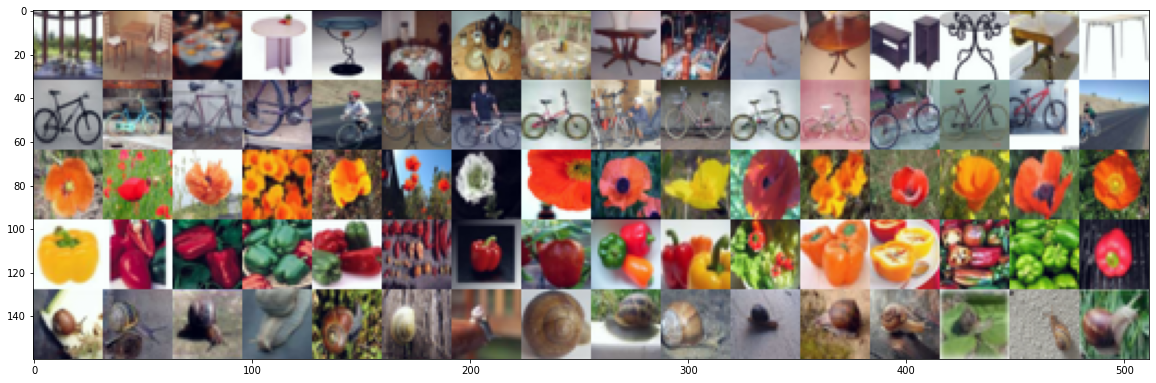

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1)
episode = next(iter(loader)) # you can for loop the loader. for episode in loader ....
pprint(episode.keys())
model.episode_to_image(episode)
pylab.figure(figsize=(20,10))
pylab.imshow(pylab.imread('./tmp/episode.png'))

##### Baseline

In [ ]:
def train(support_features, support_labels, model, loss_fn):

    model.train()
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    losses = []
    total_loss = 0
    correct = 0
    for epoch in range(100):
      optimizer.zero_grad()

      outputs = model(support_features)
      loss = loss_fn(outputs, support_labels)
      losses.append(loss.item())
      total_loss += loss.item()
      loss.backward()
      optimizer.step()

      # Evaluate on training set
      pred = outputs.max(1)[1]
    return model, total_loss

In [ ]:
transforms = transforms.Compose([
                                 transforms.Resize(32),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])])

In [ ]:
from PIL import Image
dic = {}
for label in test_labels:
  image_list = []
  for img in dic_labels[label]:
    img = transforms(img)
    image_list.append(img)
  dic[label] = image_list

In [ ]:
# Baseline
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")

for episode in tqdm(loader):
  b, nq, c, h, w = episode['query_set'].size()
  images = []
  for support_label in torch.squeeze(episode['support_absolute_labels']):
    label = labels[support_label.item()]
    images.append(dic[label][:9])
  images = list(itertools.chain(*images))
  images=torch.cat(images, 0).view(1,5,9,3,32,32)
  support_set = torch.cat([episode['support_set'].view(1,5,1,3,32,32), images], 2).contiguous()
  b, n, k, c, h, w = support_set.size() # batch, n-way,  k-shot, 3, 32, 32
  support_labels = episode['support_labels'].repeat_interleave(10).contiguous()

  model.eval()
  with torch.no_grad():
    support_features = model.backbone(support_set.view(b*n*k, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())

  linear_clf = nn.Linear(512, 5).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  linear_clf, loss_train = train(support_features.to(device), support_labels.view(-1).to(device), linear_clf, loss_fn)
  scores = linear_clf(query_features)
  pred = scores.data.cpu().numpy().argmax(axis = 1)
  accuracy += np.mean(pred == episode['query_labels'].numpy())*100

print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)


  0%|          | 0/600 [00:00<?, ?it/s]

accuracy: 67.65111111111115%


##### Baseline++

In [ ]:
from torch.nn.utils.weight_norm import WeightNorm
class distLinear(nn.Module):
  def __init__(self, indim, outdim):
    super(distLinear, self).__init__()
    self.L = nn.Linear(indim, outdim, bias = False)
    # split the weight update component to direction and norm
    WeightNorm.apply(self.L, 'weight', dim=0)

    # multiply the cosine similarity by a constant scalar
    self.scale_factor = 10
    
  def forward(self, x):
    x_norm = torch.norm(x, p=2, dim =1).unsqueeze(1).expand_as(x)
    x_normalized = x.div(x_norm + 0.00001)
    # matrix product by forward function, but when using WeightNorm, this also multiply the cosine distance by a class-wise learnable norm
    cos_dist = self.L(x_normalized) # cosine distance
    scores = self.scale_factor*(cos_dist) 

    return scores

In [ ]:
# Baseline ++
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")

for episode in tqdm(loader):
  b, nq, c, h, w = episode['query_set'].size()
  images = []
  for support_label in torch.squeeze(episode['support_absolute_labels']):
    label = labels[support_label.item()]
    images.append(dic[label][:9])
  images = list(itertools.chain(*images))
  images=torch.cat(images, 0).view(1,5,9,3,32,32)
  support_set = torch.cat([episode['support_set'].view(1,5,1,3,32,32), images], 2).contiguous()
  b, n, k, c, h, w = support_set.size() # batch, n-way,  k-shot, 3, 32, 32
  support_labels = episode['support_labels'].repeat_interleave(10).contiguous()

  model.eval()
  with torch.no_grad():
    support_features = model.backbone(support_set.view(b*n*k, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())

  linear_clf = distLinear(512, 5).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  linear_clf, loss_train = train(support_features.to(device), support_labels.view(-1).to(device), linear_clf, loss_fn)
  scores = linear_clf(query_features.to(device))
  pred = scores.data.cpu().numpy().argmax(axis = 1)
  accuracy += np.mean(pred == episode['query_labels'].numpy())*100

print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)


  0%|          | 0/600 [00:00<?, ?it/s]

accuracy: 69.27333333333341%


### Images loaded from a Drive folder

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torchvision.transforms as transforms
transforms = transforms.Compose([
                                 transforms.Resize(32),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])])

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
!ls

'Copia de Lab0.ipynb'   DALLE_MINI.ipynb       fewshot-icgan.ipynb
 DALLE		        DALLE_Mini_TFG.ipynb   hash_lab.ipynb
 DALL-E		        Dalle_Mini_V1.ipynb    Lab0.ipynb
 DALLE_Mini.ipynb       data.pkl


In [ ]:
dic_labels = {}
for label in test_labels:
  image_list = []
  for filename in glob.glob(os.path.join("/content/gdrive/My Drive/Colab Notebooks/DALL-E", label, '*.jpeg')):
    img = Image.open(filename)
    img = transforms(img)
    image_list.append(img)
  dic_labels[label] = image_list

#### Baseline

In [ ]:
# Baseline
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")

for episode in tqdm(loader):
  b, nq, c, h, w = episode['query_set'].size()
  images = []
  for support_label in torch.squeeze(episode['support_absolute_labels']):
    label = labels[support_label.item()]
    images.append(dic_labels[label][:9])
  images = list(itertools.chain(*images))
  images=torch.cat(images, 0).view(1,5,9,3,32,32)
  support_set = torch.cat([episode['support_set'].view(1,5,1,3,32,32), images], 2).contiguous()
  b, n, k, c, h, w = support_set.size() # batch, n-way,  k-shot, 3, 32, 32
  support_labels = episode['support_labels'].repeat_interleave(10).contiguous()

  model.eval()
  with torch.no_grad():
    support_features = model.backbone(support_set.view(b*n*k, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())

  linear_clf = nn.Linear(512, 5).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  linear_clf, loss_train = train(support_features.to(device), support_labels.view(-1).to(device), linear_clf, loss_fn)
  scores = linear_clf(query_features)
  pred = scores.data.cpu().numpy().argmax(axis = 1)
  accuracy += np.mean(pred == episode['query_labels'].numpy())*100

print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)


  0%|          | 0/600 [00:00<?, ?it/s]

accuracy: 72.83333333333337%


#### Baseline++

In [ ]:
# Baseline ++
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")

for episode in tqdm(loader):
  b, nq, c, h, w = episode['query_set'].size()
  images = []
  for support_label in torch.squeeze(episode['support_absolute_labels']):
    label = labels[support_label.item()]
    images.append(dic_labels[label][:9])
  images = list(itertools.chain(*images))
  images=torch.cat(images, 0).view(1,5,9,3,32,32)
  support_set = torch.cat([episode['support_set'].view(1,5,1,3,32,32), images], 2).contiguous()
  b, n, k, c, h, w = support_set.size() # batch, n-way,  k-shot, 3, 32, 32
  support_labels = episode['support_labels'].repeat_interleave(10).contiguous()

  model.eval()
  with torch.no_grad():
    support_features = model.backbone(support_set.view(b*n*k, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())

  linear_clf = distLinear(512, 5).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  linear_clf, loss_train = train(support_features.to(device), support_labels.view(-1).to(device), linear_clf, loss_fn)
  scores = linear_clf(query_features.to(device))
  pred = scores.data.cpu().numpy().argmax(axis = 1)
  accuracy += np.mean(pred == episode['query_labels'].numpy())*100

print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)


  0%|          | 0/600 [00:00<?, ?it/s]

accuracy: 76.66444444444446%
